In this notebook I will be finding the best algorithm and parameters to predict whether or not people will pay off their loans. Orginially, I tested about 15-20 models through grid search, with a variety of attributes--balanced vs. unbalanced target variables, data normalization etc. Here I will only show a snippet of that code.

Keep in mind, the goal of this project was not to get the highest accuracy, but to get the highest precision on correctly predicting a loan will be paid off. To get the highest precision possible, I sacrificed a lot of good loans to ensure the loans the algorithm claimed would be paid off were almost certainly paid off.

The reason I did this, is because I was making this algorithm to be used by a hypothetical everday person (compared to a big bank) who would be very sensitive to losses.

In [100]:
import pandas as pd
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import re
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import  Normalizer, normalize
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve,make_scorer, precision_score, average_precision_score,precision_recall_fscore_support, accuracy_score

In [5]:
loan_features = pd.read_pickle("loans_features.pkl")

In [10]:
loan_target = pd.read_pickle("loans_target.pkl")

I created the below function so I could try fitting models with different variations of the data. I will show some examples of it's use. However, the best results were obtained with normalization and a resample_split of 1 (meaning, in the training set, the ratio of paid off to charged of loans was around 1:1.

In [13]:
def sample_split(X, Y, test_size=.3, Normalize="Yes" ,resample_split=.9):
    """Resample split determines how balanced the classes should be. Resample split of 1 would be 50/50. Splits below
    one would mean more fully paid data than charged off data. Essentially, the purpose of resample split is to
    downsample the majority class (Fully Paid)."""
    if Normalize == "Yes":
        X = pd.DataFrame(normalize(X, axis= 0, norm="max"))
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= test_size )
    if resample_split:
        combined = x_train
        combined['y_variable'] = y_train.values
        
        sample_amount = int(len(combined[combined.y_variable == "Charged Off"])*resample_split)
        fully_resample = combined[combined.y_variable == "Fully Paid"].sample(sample_amount)
        combined_fix = pd.concat([combined[combined.y_variable == "Charged Off"], fully_resample])
        x_train = combined_fix.drop('y_variable', 1)
        y_train = combined_fix['y_variable']
    return x_train, x_test, y_train, y_test
    

In [26]:
#what do the results looks like if we don't balance the classes in the training set?
x_train_unb, x_test_unb, y_train_unb, y_test_unb= sample_split(loan_features, loan_target,test_size= .20,resample_split=None, Normalize="Yes")


In [49]:
#Regular SVC will take a very long time to run
SVC = LinearSVC()
PS = make_scorer(precision_score, pos_label="Fully Paid")
parameters = {"C": [10,15,30,50,100], "dual": [False], "penalty":["l1"], "loss":["squared_hinge"] }
LinearSVC_l1_unb = GridSearchCV(SVC, parameters, scoring=PS)

In [50]:
LinearSVC_l1_unb.fit(x_train_unb, y_train_unb)
LinearSVC_l1_unb.score(x_test_unb, y_test_unb)
#score is precision score

0.81993861993861994

In [51]:
print(classification_report(y_test_unb, LinearSVC_l1_unb.predict(x_test_unb)))

             precision    recall  f1-score   support

Charged Off       0.59      0.01      0.01      9147
 Fully Paid       0.82      1.00      0.90     41448

avg / total       0.78      0.82      0.74     50595



In [52]:
accuracy_score(y_test_unb, LinearSVC_l1_unb.predict(x_test_unb))

0.81952762130645318

With unbalanced classes, we get a pretty good accuracy...but that accuracy would be the same if we just picked "Fully Paid" for all loans. Precision here is no better than chance...we can do better.

In [38]:
nb_unb = GaussianNB()
nb_unb.fit(x_train_unb, y_train_unb)
nb_unb.score(x_test_unb,y_test_unb)
#score is accuracy score

0.22087162763118887

In [44]:
print(classification_report(y_test_unb, nb_unb.predict(x_test_unb)))

             precision    recall  f1-score   support

Charged Off       0.18      0.97      0.31      9147
 Fully Paid       0.88      0.06      0.11     41448

avg / total       0.76      0.22      0.14     50595



Naive bayes does better precision wise, but at the huge cost of accuracy and recall...too much of a hit...let's keep trying.

In [54]:
#Logistic Regression and LinearSVC has a class_weight: balanced parameter..Let's see how well that works:
Lor= LogisticRegression()
parameters = {"class_weight": [None, "balanced"], "C": [3,5,9], "solver": ["sag"], "max_iter":[300] }
PS = make_scorer(precision_score, pos_label="Fully Paid")
LR_unb = GridSearchCV(Lor, parameters, scoring=PS)

In [55]:
LR_unb.fit(x_train_unb, y_train_unb)
LR_unb.score(x_test_unb,y_test_unb)


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached w

0.89736769379577175

In [59]:
accuracy_score(y_test_unb, LR_unb.predict(x_test_unb))

0.63549757881213553

In [60]:
LR_unb.best_estimator_
#unsuprisingly Gridsearch selected the "balanced" class_weight as being better than no class weight

LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=300,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [61]:
print(classification_report(y_test_unb, LR_unb.predict(x_test_unb)))

             precision    recall  f1-score   support

Charged Off       0.29      0.68      0.40      9147
 Fully Paid       0.90      0.63      0.74     41448

avg / total       0.79      0.64      0.68     50595



Some algorithms can't natively balance the classes so we need to do that ourselves.

In [ ]:
x_train, x_test, y_train, y_test= sample_split(loan_features, loan_target,test_size= .20,resample_split=1, Normalize="Yes")


In [18]:
#balanced classes
y_train.value_counts()

Fully Paid     36102
Charged Off    36102
Name: y_variable, dtype: int64

In [20]:
#actual distribution in real life (I want the model to be able to predict on this unbalanced distribution)
y_test.value_counts()

Fully Paid     41449
Charged Off     9146
Name: loan_status, dtype: int64

In [22]:
SVC = LinearSVC()
PS = make_scorer(precision_score, pos_label="Fully Paid")
parameters = {"C": [10,15,30,50,100], "class_weight": ["balanced"], "dual": [False], "penalty":["l1"], "loss":["squared_hinge"] }
LinearSVC_l1 = GridSearchCV(SVC, parameters, scoring=PS)

In [23]:
LinearSVC_l1.fit(x_train, y_train)
LinearSVC_l1.score(x_test, y_test)
#score is precision score

0.89318151009895619

In [25]:
print(classification_report(y_test, LinearSVC_l1.predict(x_test)))

             precision    recall  f1-score   support

Charged Off       0.28      0.66      0.40      9146
 Fully Paid       0.89      0.64      0.74     41449

avg / total       0.78      0.64      0.68     50595



In [33]:
accuracy_score(y_test, LinearSVC_l1.predict(x_test))

0.63939124419409032

In [45]:
nb = GaussianNB()
nb.fit(x_train, y_train)
nb.score(x_test,y_test)

0.23338274533056627

In [46]:
print(classification_report(y_test, nb_unb.predict(x_test)))

             precision    recall  f1-score   support

Charged Off       0.18      0.97      0.31      9146
 Fully Paid       0.89      0.06      0.11     41449

avg / total       0.76      0.22      0.14     50595



Naive Bayes does fairly poorly, accuracy-wise, independent if classes are balanced or not. It has high precision for fully paid class, but at a huge cost of recall (meaning it is selecting only a small percentage of loans that are fully paid, but the ones it does select are almost all True positives).

In [72]:
GBC = GradientBoostingClassifier()
PS = make_scorer(precision_score, pos_label="Fully Paid")
parameters = {"learning_rate": [.01], "n_estimators": [300], "max_depth":[3,7], "subsample":[1], "min_samples_leaf":[6,7], "max_features": ["sqrt"] }
GB = GridSearchCV(GBC, parameters, scoring=PS)

In [73]:
GB.fit(x_train, y_train)
GB.score(x_test, y_test)

0.89465280608778364

In [74]:
accuracy_score(y_test, GB.predict(x_test))

0.63998418816088543

In [75]:
print(classification_report(y_test, GB.predict(x_test)))

             precision    recall  f1-score   support

Charged Off       0.29      0.66      0.40      9146
 Fully Paid       0.89      0.64      0.74     41449

avg / total       0.78      0.64      0.68     50595



In [102]:
ABC = AdaBoostClassifier()
PS = make_scorer(precision_score, pos_label="Fully Paid")
parameters = {"n_estimators": [100,200], "learning_rate": [1, 2]}
ABCGS = GridSearchCV(ABC, parameters, scoring=PS)

In [107]:
ABCGS.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200], 'learning_rate': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(precision_score, pos_label=Fully Paid),
       verbose=0)

In [112]:
ABCGS.score(x_test, y_test)

0.89556630254658598

In [110]:
ABCGS.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=200, random_state=None)

In [111]:
print(classification_report(y_test, ABCGS.predict(x_test)))

             precision    recall  f1-score   support

Charged Off       0.29      0.66      0.40      9146
 Fully Paid       0.90      0.64      0.75     41449

avg / total       0.79      0.64      0.68     50595



All of these algorithms give roughly the same results (with the exception of Naive Bayes). Let's take a look at the Gradient Boosted Trees one and see what the most important features were.

In [77]:
GB.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=7,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=7,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=None,
              subsample=1, verbose=0, warm_start=False)

In [78]:
#GridSearch does not all us to grab the best features. So we have to run Gradient Boost by itself with the best
#parameters to grab them

GB = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=7,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=7,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=None,
              subsample=1, verbose=0, warm_start=False)
GB.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=7,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=7,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=None,
              subsample=1, verbose=0, warm_start=False)

In [79]:
tuples = []
for x,y in zip(GB.feature_importances_, loan_features):
    tuples.append([x,y])
tuples = sorted(tuples, key= lambda x: abs(x[0]), reverse=True)

In [81]:
tuples[0:5]

[[0.19473353620969852, 'int_rate'],
 [0.11344683116829837, 'annual_inc'],
 [0.086323955599068039, 'dti'],
 [0.078222069340860151, 'A'],
 [0.049524937258668661, 'revol_util']]

In [85]:
#renaming the best features so they are easier to understand
tuples[0][1] = "Interest Rate"
tuples[1][1] = "Annual Income"
tuples[2][1] = "Loan Amount"
tuples[3][1] = "Revolving Utilization"
tuples[4][1] = "Debt to Income"
tuples[5][1] = "Total Credit Accounts"
tuples[6][1] = "Revolving Balance"
tuples[7][1] = "Small Business"
tuples[8][1] = "Inquiry Last 6 months"
tuples[9][1] = "Length of Credit History"
tuples[10][1] = "Renting Home"


In [86]:
#making it easier to plot
A = [x for x,y in tuples]
B = [y for x,y in tuples]

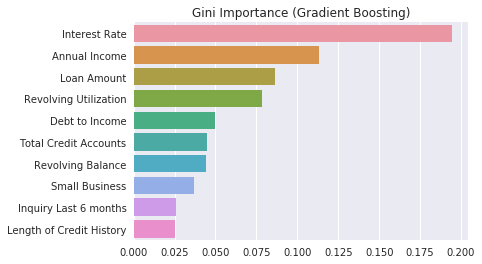

In [87]:
sns.barplot(A[:10], B[:10])
plt.title("Gini Importance (Gradient Boosting)")

Unsuprisingly interest rate, a proxy for loan grade/risk, was the most important feature. Annual Income and loan amount were also really important...which makes  sense.

Let's look at a precision recall curve for some of these algorithms:

In [95]:
precision, recall, _ = precision_recall_curve(y_test, GB.predict_proba(x_test)[:,1], pos_label="Fully Paid")

In [94]:
precision1, recall1, _ = precision_recall_curve(y_test_unb, LR_unb.predict_proba(x_test_unb)[:,1], pos_label="Fully Paid")

In [115]:
precision2, recall2, _ = precision_recall_curve(y_test, ABCGS.predict_proba(x_test)[:,1], pos_label="Fully Paid")

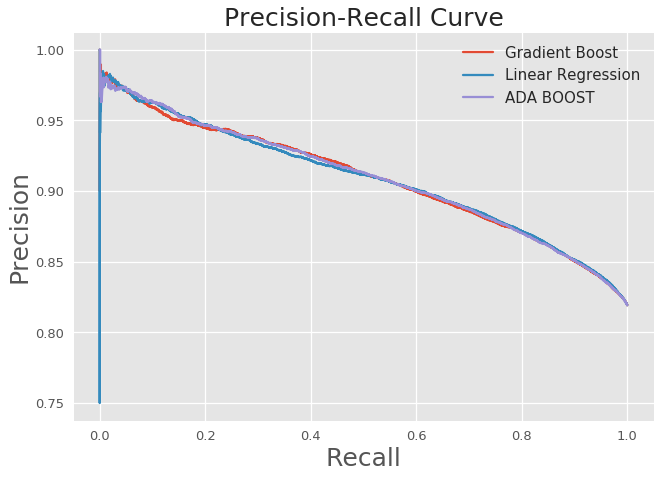

In [116]:
sns.set_context("talk")

plt.style.use('ggplot')
plt.plot(recall, precision, label="Gradient Boost")
plt.plot(recall1, precision1, label="Linear Regression")
plt.plot(recall2, precision2, label="ADA BOOST")



plt.xlabel('Recall', size=25)
plt.ylabel('Precision', size=25)
plt.legend(fontsize=15)
plt.title("Precision-Recall Curve", size=25)
#not sure what is causing that blip in linear regression at the beginning. It is worth examining more.

Again, all are preforming roughly similar. It may be feasible, if anyone were to actually use this algorithm, and were really sensitive to loses, to increase the probability threshold from .5 to like .7. Pushing the precision to .95-.97 (but at a huge cost of recall, which is fine if you are only investing in a limited amount of loans).